<a href="https://colab.research.google.com/github/erikamoore/sam-i-am/blob/main/sam2_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## this notebook builds off the following resources:
- [Meta AI – Segment Anything Model 2 (SAM2)](https://github.com/facebookresearch/segment-anything-2)  
- [Roboflow – SAM2 Video Segmentation Tutorial](https://github.com/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-videos-with-sam-2.ipynb)





---



## setup, imports, installs


In [1]:
IS_COLAB = True
import os
import sys

In [2]:
# ================== GPU diagnostic info ========================
!nvidia-smi
HOME = os.getcwd()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print("HOME:", HOME)

Thu May  8 18:03:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   33C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# ======================== installs ================================
!git clone https://github.com/facebookresearch/sam2.git
%cd {HOME}/sam2

# overwrite with modified file to limit caching (see issue #264)
!wget -O sam2/utils/misc.py https://raw.githubusercontent.com/erikamoore/sam-i-am/main/misc_v2.py

!pip install -e . -q
!python setup.py build_ext --inplace
!pip install -q supervision[assets] jupyter_bbox_widget

# model checkpoints (changed to be 2.1 models)
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2.1_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2.1_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P {HOME}/checkpoints


Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
--2025-05-08 18:03:58--  https://raw.githubusercontent.com/erikamoore/sam-i-am/main/misc_v2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10891 (11K) [text/plain]
Saving to: ‘sam2/utils/misc.py’

sam2/utils/misc.py  100%[===================>]  10.64K  --.-KB/s    in 0s      

2025-05-08 18:03:58 (118 MB/s) - ‘sam2/utils/misc.py’ saved [10891/10891]

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... d

In [4]:
# ======================== general imports =============================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import base64
import supervision as sv
from pathlib import Path
from supervision.assets import download_assets, VideoAssets

# widget specific imports
if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

# more GPU setup
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
# ======================== helper functions =============================

# from meta's video notebook
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# from image notebook
def show_mask2(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# from meta's image notebook
def show_masks2(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask2(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# for the displaying the widget
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [6]:
%pwd

'/content/sam2'

## model checkpoints and config

In [7]:
# ======================== SAM2 imports =============================
import sys
sys.path.append(f"{HOME}/sam2")

from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

# CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_large.pt"
CHECKPOINT = f"{HOME}/checkpoints/sam2.1_hiera_base_plus.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_b+.yaml"


In [8]:
%cd ..

/content


## load video and split into frames

In [9]:
# path to our uploaded video
SOURCE_VIDEO = "3tiny_1m.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

# scale the video for memory efficiency
SCALE_FACTOR = 0.6
START_IDX = 0
END_IDX = 1800

# split video frames and put in directory
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=END_IDX)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

# path to our eventual output
TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-out.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

In [10]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info

VideoInfo(width=1440, height=1080, fps=30, total_frames=1817)

## set up predictor objects

In [12]:
# build an image predictor
sam2_model=build_sam2(CONFIG, CHECKPOINT, DEVICE)
ipredictor = SAM2ImagePredictor(sam2_model)


# separately, build a video predictor

# corrections didnt seem to work without this line
vpredictor = build_sam2_video_predictor(CONFIG, CHECKPOINT, DEVICE,
                                        non_overlap_masks=True,
                                        hydra_overrides_extra=
                                        ["++model.add_all_frames_to_correct_as_cond=True"])


# new change to try with offload_state_to_cpu
inference_state = vpredictor.init_state(video_path=SOURCE_FRAMES.as_posix(),
                                        async_loading_frames=True,
                                        offload_video_to_cpu=True,
                                        offload_state_to_cpu=True)




using the modified misc file to load frames from disk and not cache.
using the modified misc file to load frames from disk and not cache.


In [13]:
#  ======================== reset predictors as needed =============================

# resets image predictor embeddings and state variables
ipredictor.reset_predictor()

# reset video predictor's inference state
vpredictor.reset_state(inference_state)

In [14]:
OBJECTS = ['obj1', 'obj2', 'obj3']

# create a unique integer label for each object
obj_to_ann_id = {obj: i for i, obj in enumerate(OBJECTS)}

In [15]:
# inference state has a built in so we dont actually need this
obj_to_ann_id

{'obj1': 0, 'obj2': 1, 'obj3': 2}

In [ ]:
# get widget


FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

In [28]:
widget.bboxes

[{'x': 418, 'y': 453, 'width': 24, 'height': 30, 'label': 'obj1'},
 {'x': 567, 'y': 418, 'width': 17, 'height': 42, 'label': 'obj2'},
 {'x': 725, 'y': 442, 'width': 39, 'height': 19, 'label': 'obj3'}]

In [29]:
# prepare image predictor
IMAGE_PATH = FRAME_PATH
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
ipredictor.set_image(image_rgb)
print(ipredictor._features["image_embed"].shape, ipredictor._features["image_embed"][-1].shape)


torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


In [30]:
# maps obj id to a nested dict of frames of masks for that object
inference_state["mask_inputs_per_obj"]

{}

object label is obj1
box_arr is [[418 453 442 483]]
box_arr.shape is (1, 4)
processed obj1
masks.shape: (3, 648, 864), scores: [0.7578125  0.74609375 0.71484375]


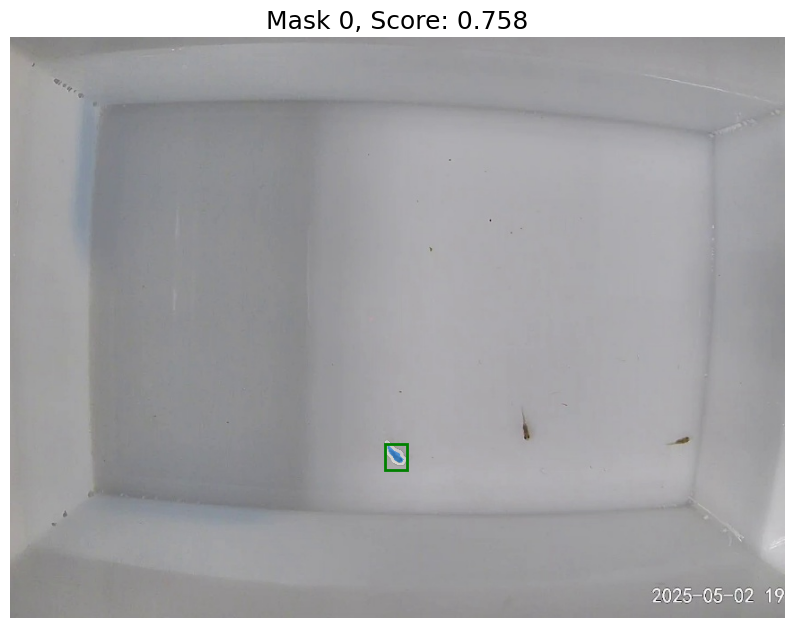

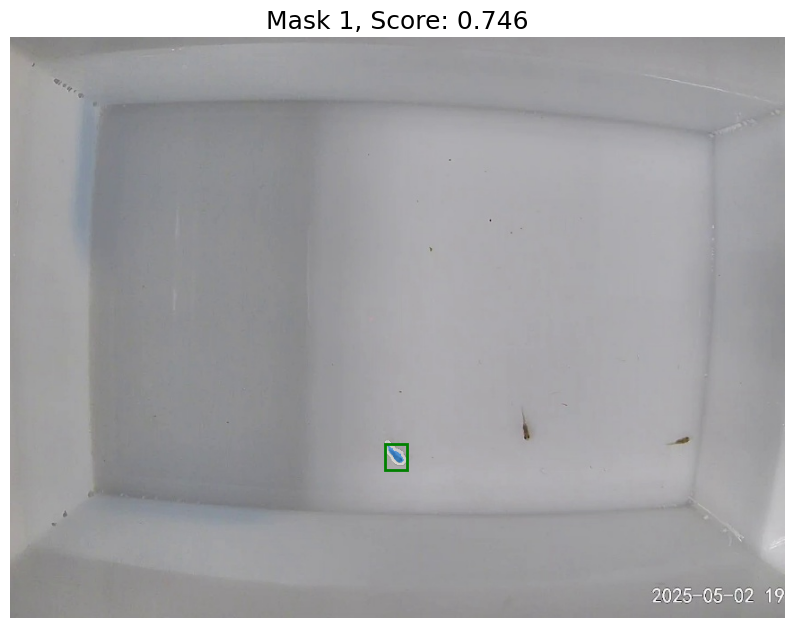

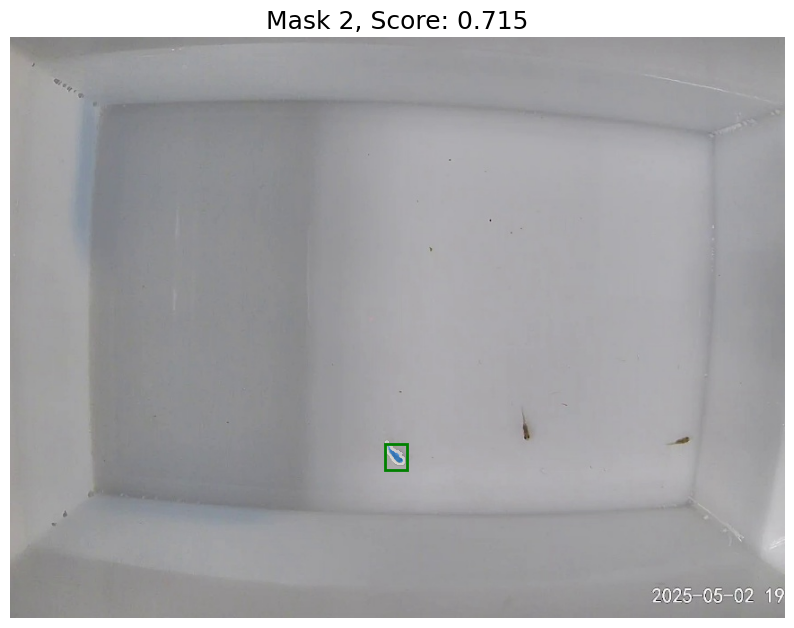


object label is obj2
box_arr is [[567 418 584 460]]
box_arr.shape is (1, 4)
processed obj2
masks.shape: (3, 648, 864), scores: [0.79296875 0.77734375 0.7734375 ]


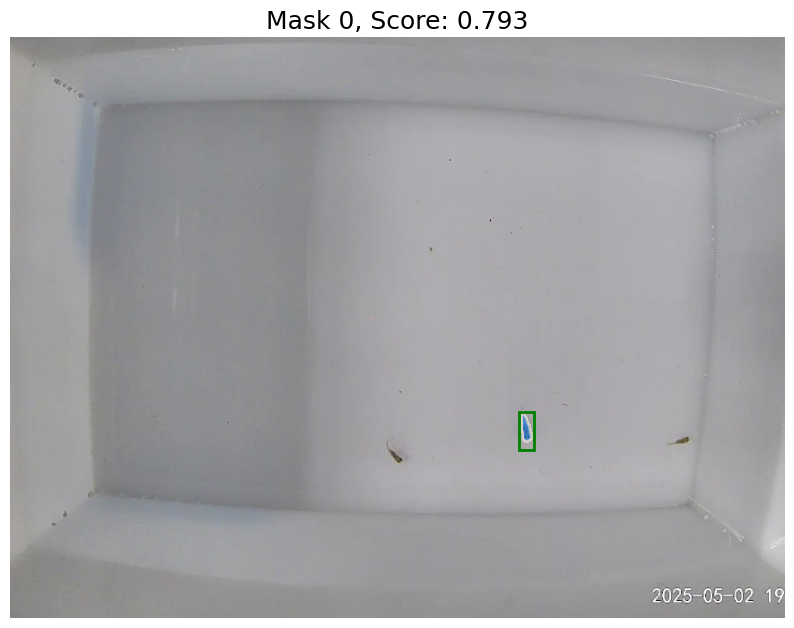

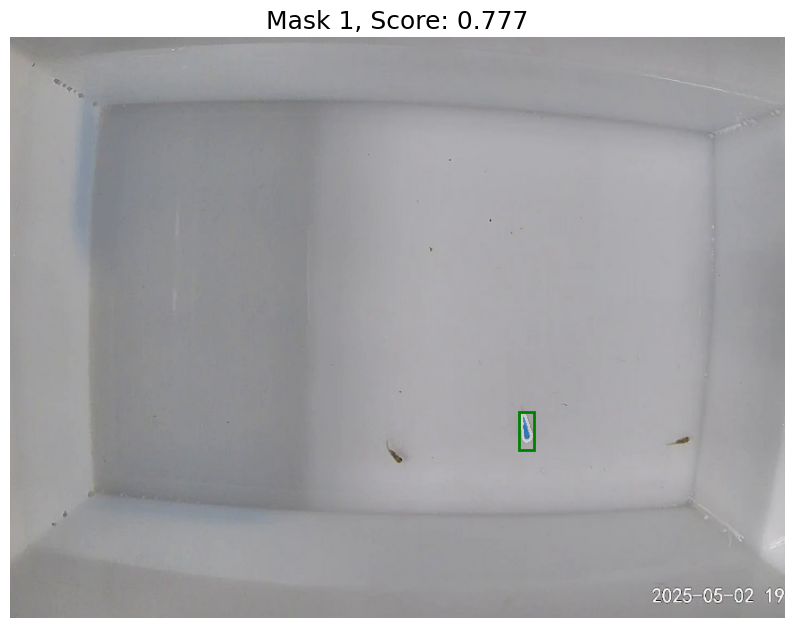

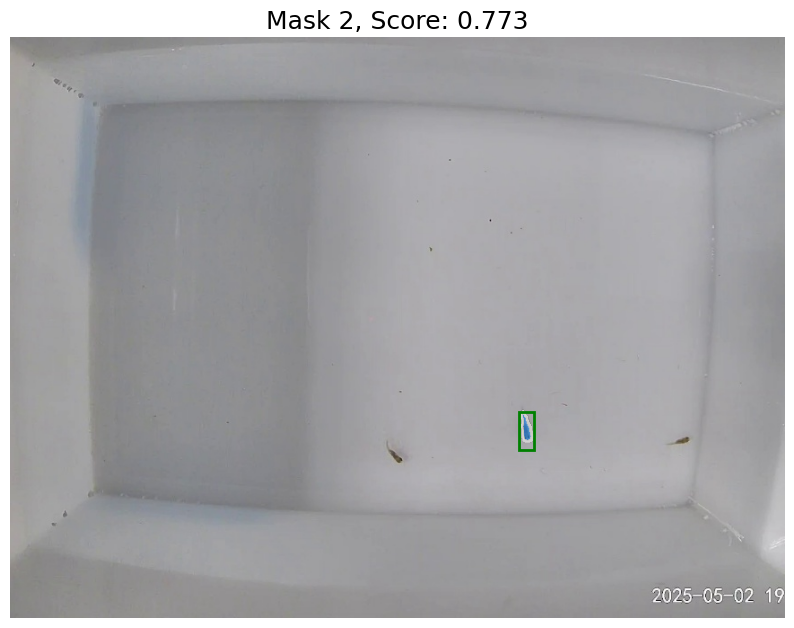


object label is obj3
box_arr is [[725 442 764 461]]
box_arr.shape is (1, 4)
processed obj3
masks.shape: (3, 648, 864), scores: [0.8046875  0.78515625 0.765625  ]


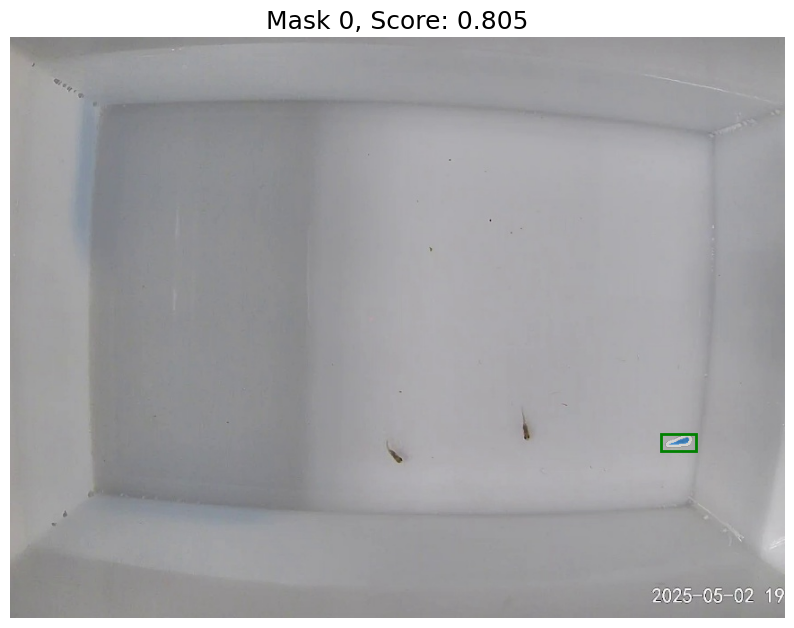

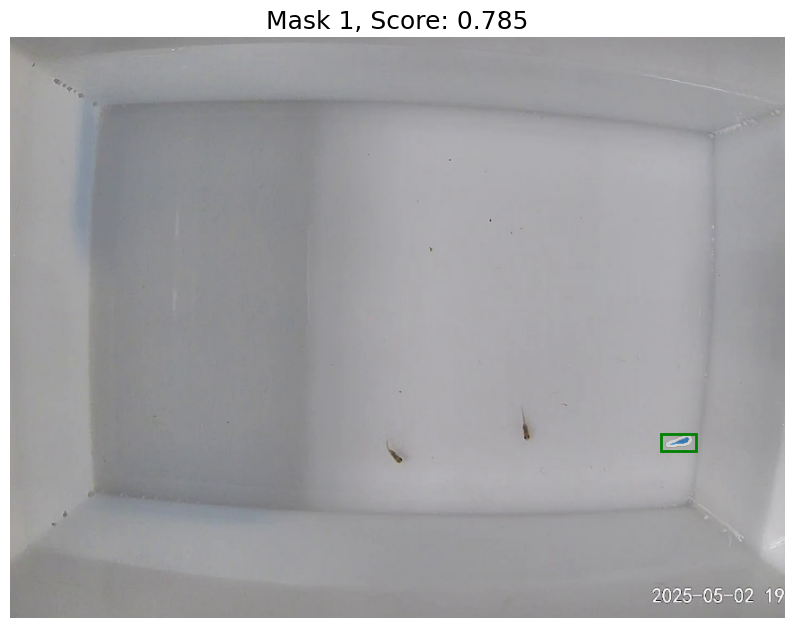

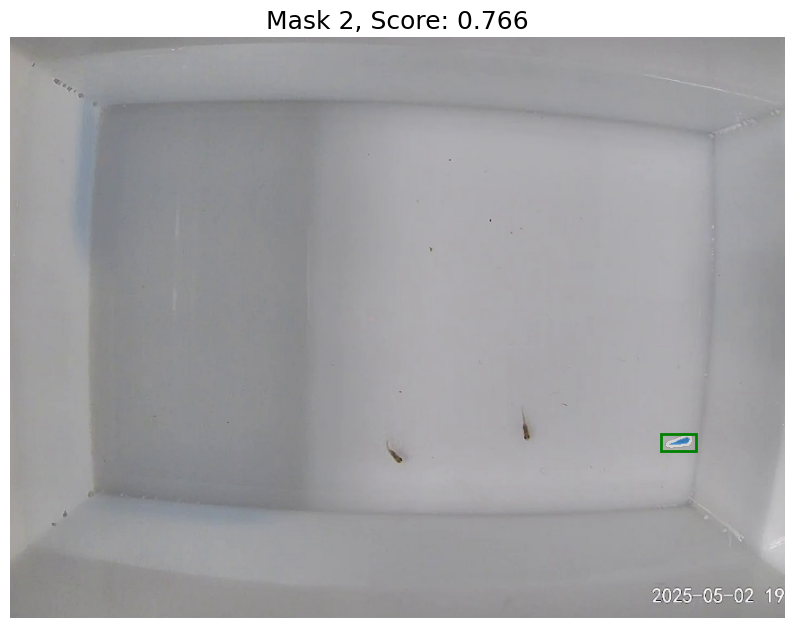


All predicted masks on this frame have been shown.


In [31]:
# just so the code doesn't break if we do not use widget
default_box = [{'x': 490, 'y': 423, 'width': 77, 'height': 64, 'label': 'obj1'},
 {'x': 131, 'y': 551, 'width': 186, 'height': 81, 'label': 'obj2'},
 {'x': 483, 'y': 576, 'width': 94, 'height': 194, 'label': 'obj3'}]

# get ipredictor masks for each bbox
all_ipreds = {}

# roboflow had a default box as backup
boxes = widget.bboxes if len(widget.bboxes) > 0 else default_box

for object_id, label in enumerate(OBJECTS):
    print(f"object label is {label}")
    box_list = [box for box in boxes if box['label'] == label]
    if len(box_list) == 0:
        continue

    # this was modified from the points array
    # check that this is the correct form. meta used dim (4,).
    box_arr = np.array([
            (box['x'],
            box['y'],
            box['x'] + box['width'],
            box['y'] + box['height'])
         for box in box_list
    ])

    input_box = np.squeeze(box_arr) if box_arr.shape[0] == 1 else box_arr
    print(f"box_arr is {box_arr}")
    print(f"box_arr.shape is {box_arr.shape}")

    input_label = np.array([1])

    # get 3 predictions back per object
    masks, scores, logits = ipredictor.predict(
        # point_coords=input_point,
        box=input_box,
        point_labels=input_label,
        multimask_output=True,
    )

    # sort in order of high score to low score
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]

    # store the predictions for each object
    all_ipreds[label] = {
        "masks": masks,
        "scores": scores,
        "logits": logits,
        "box": input_box,
    }
    print(f"processed {label}\nmasks.shape: {masks.shape}, scores: {scores}")


    show_masks2(image_rgb, masks, scores, box_coords=input_box, input_labels=input_label, borders=True)
    print()

print(f"All predicted masks on this frame have been shown.")

In [32]:
from pprint import pprint
print("all_ipreds looks like:")
pprint({k: {kk: vv.shape for kk, vv in v.items()} for k, v in all_ipreds.items()})

all_ipreds looks like:
{'obj1': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)},
 'obj2': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)},
 'obj3': {'box': (4,),
          'logits': (3, 256, 256),
          'masks': (3, 648, 864),
          'scores': (3,)}}


In [33]:
# FIX THIS WE NEED TO REDEFINE EACH TIME

# dict that maps each object id to the mask num (idx) we want to keep
mask_to_choice = {
    "obj1": 0,
    "obj2": 0,
    "obj3":0,
}


In [34]:
mask_to_choice

{'obj1': 0, 'obj2': 0, 'obj3': 0}

In [35]:
def choose_masks(all_ipreds, mask_to_choice):
  """ returns a dict containing best mask, scores, and logits for each object id """
  best_masks = {}

  for obj_id, mask_num in mask_to_choice.items():
    print(f"obj_id is {obj_id}")
    print(f"choosing mask_num {mask_num}\n")


    # choose the corresponding entries from all_ipreds
    best_masks[obj_id] = {
        "box": all_ipreds[obj_id]["box"],
        "logits": all_ipreds[obj_id]["logits"][mask_num],
        "mask": all_ipreds[obj_id]["masks"][mask_num],
        "score": all_ipreds[obj_id]["scores"][mask_num],
    }

  return best_masks



In [36]:
best_masks = choose_masks(all_ipreds, mask_to_choice)

obj_id is obj1
choosing mask_num 0

obj_id is obj2
choosing mask_num 0

obj_id is obj3
choosing mask_num 0



In [37]:
obj_to_ann_id

{'obj1': 0, 'obj2': 1, 'obj3': 2}

In [38]:
FRAME_IDX

0

In [39]:
# goal add each mask to the v predictor
for obj, mask_info in best_masks.items():
  # get the unique obj id integer
  ann_obj_id = obj_to_ann_id[obj]

  # get the mask we wanted for that obj
  mask_input = mask_info['mask']
  binary_mask = (mask_input > 0).astype(np.uint8)

  # pass the object's mask to the video predictor
  vpredictor.add_new_mask(inference_state, FRAME_IDX, ann_obj_id, binary_mask)

# seemed to run...

In [40]:
prop_results = list(vpredictor.propagate_in_video(inference_state))
# after running on 1800 frames,
# 7.8/53 GB RAM used
# 15.2/22.5 GB GPU used

propagate in video: 100%|██████████| 1800/1800 [03:22<00:00,  8.90it/s]


In [41]:
# prepare for the propagation preview
video_dir= "./3tiny_1m"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

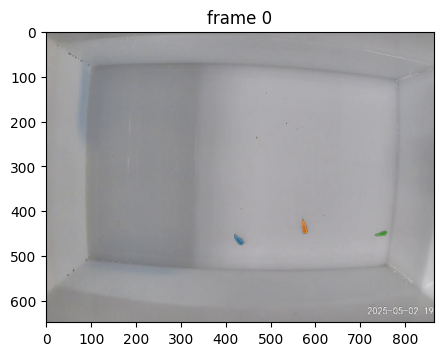

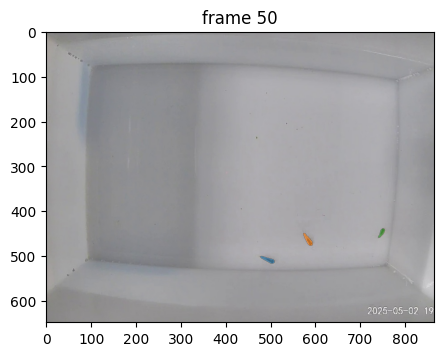

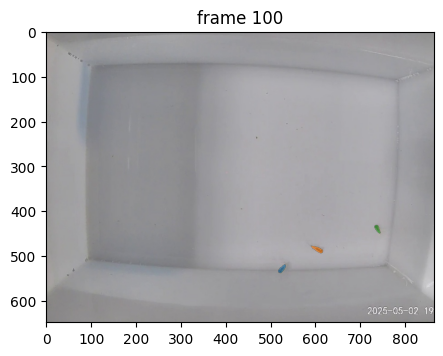

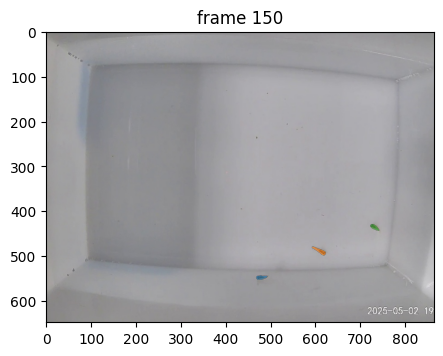

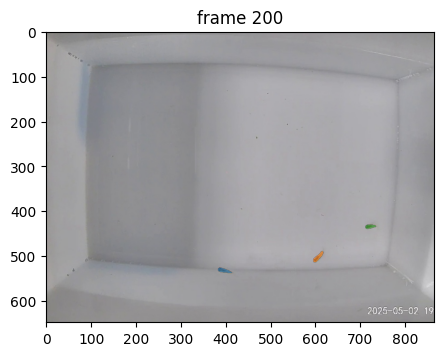

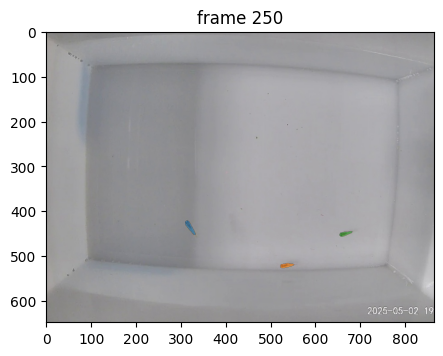

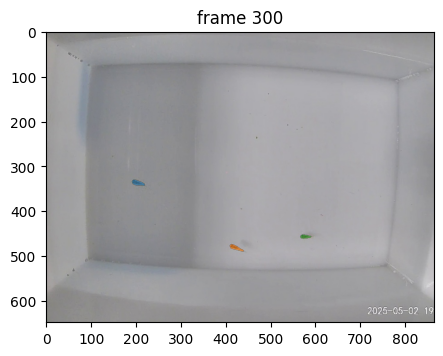

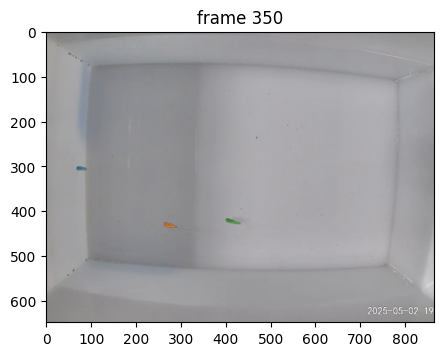

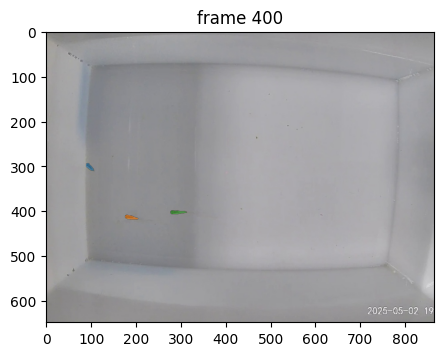

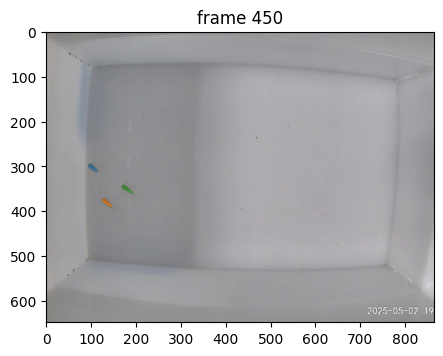

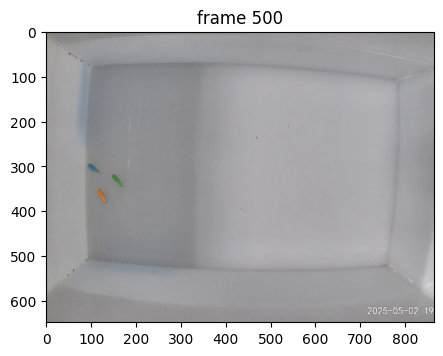

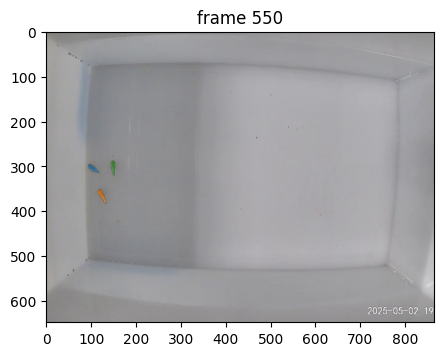

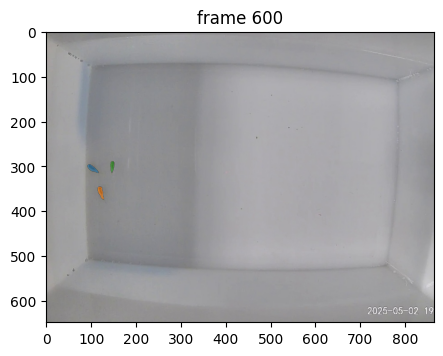

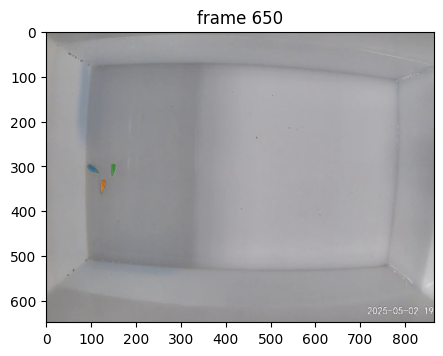

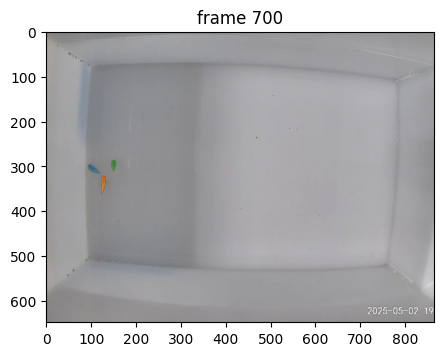

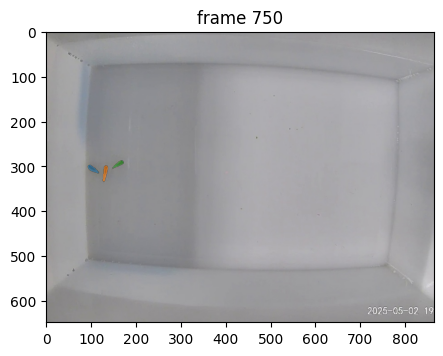

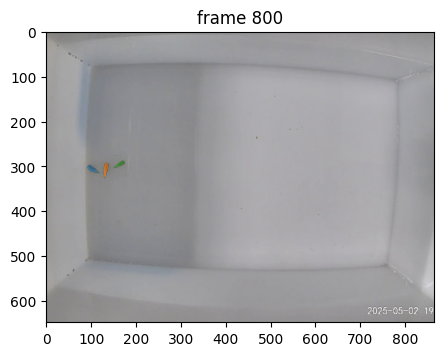

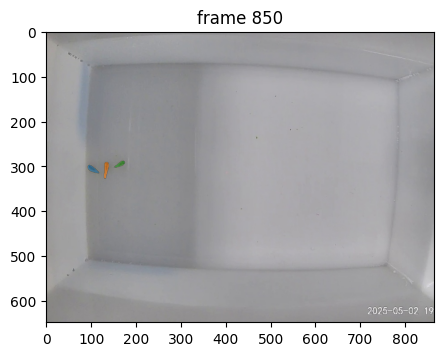

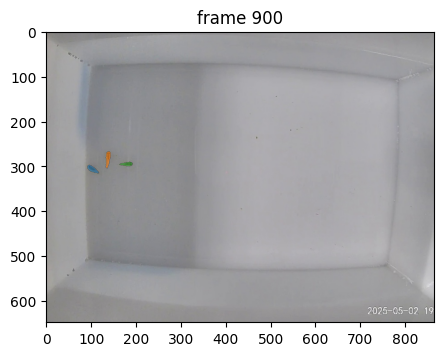

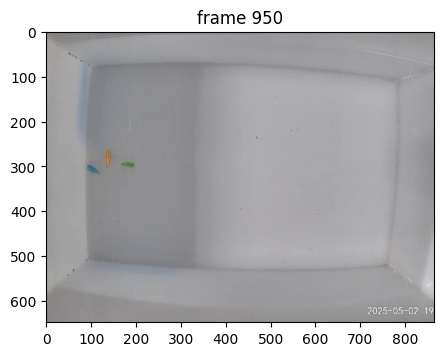

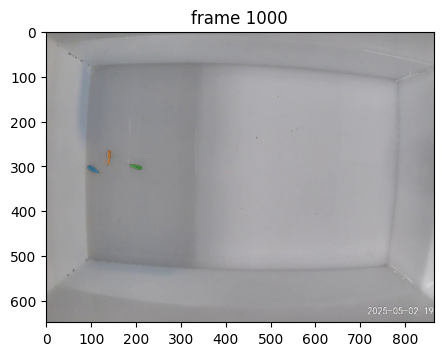

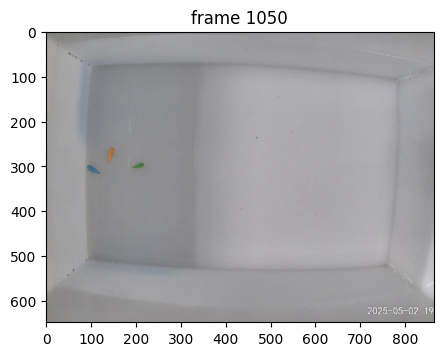

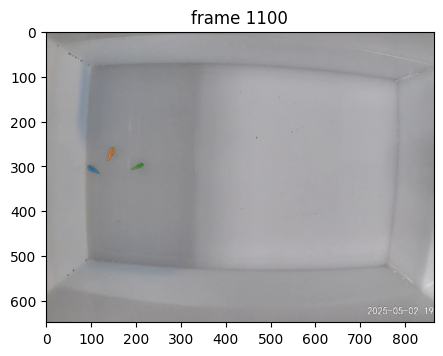

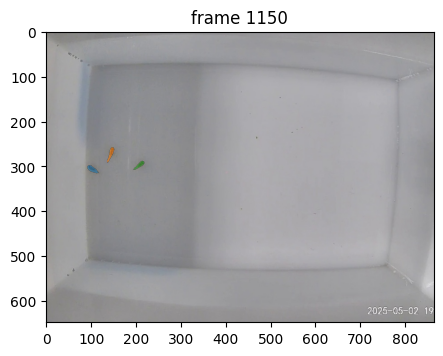

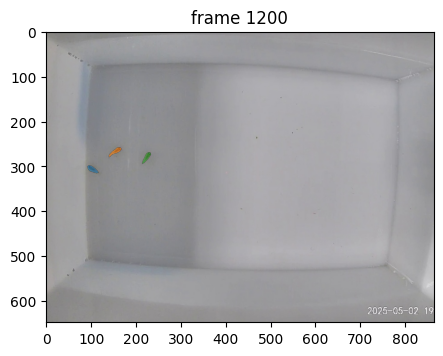

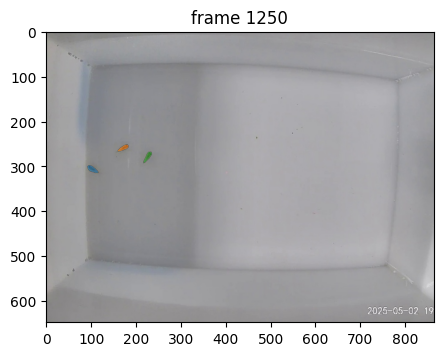

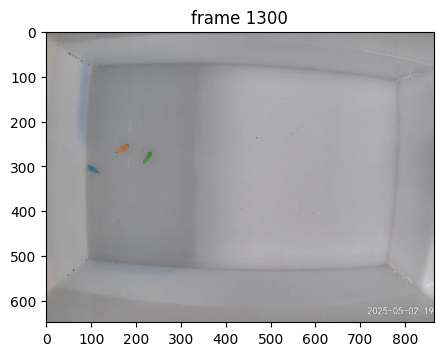

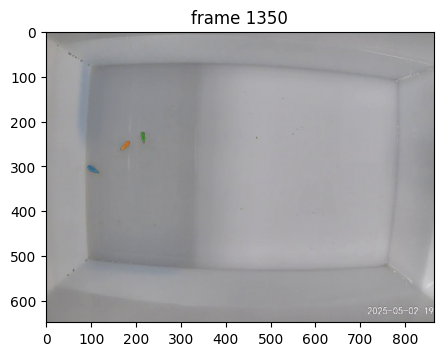

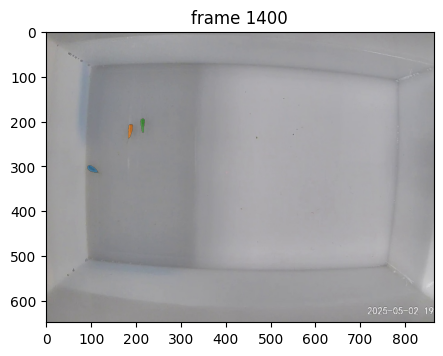

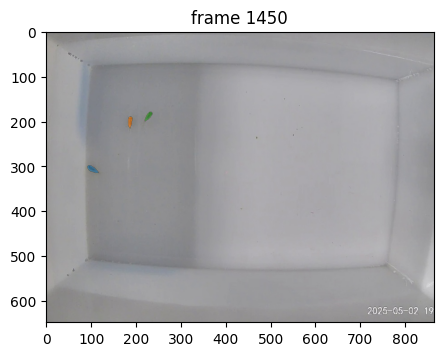

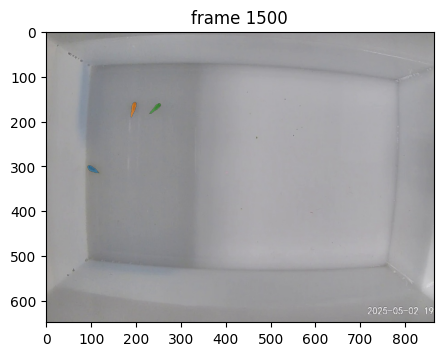

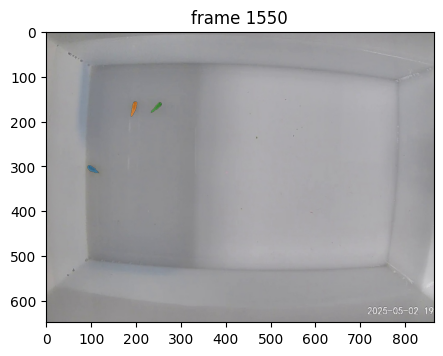

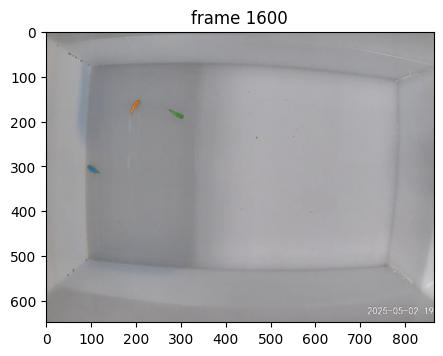

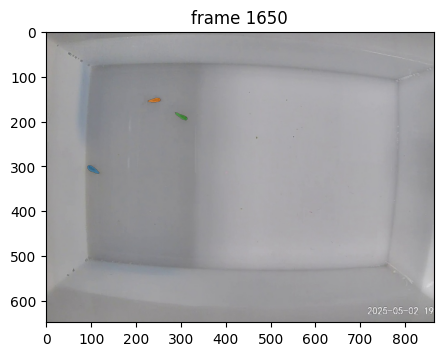

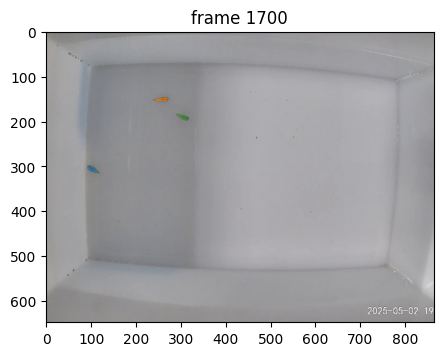

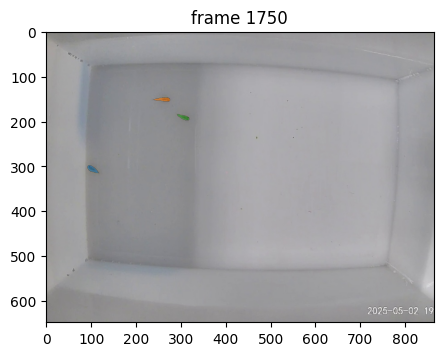

In [42]:
# collect the propagation results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results

# for out_frame_idx, out_obj_ids, out_mask_logits in vpredictor.propagate_in_video(inference_state):
for out_frame_idx, out_obj_ids, out_mask_logits in prop_results:

    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


# render the segmentation results every few frames
vis_frame_stride = 50
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(5, 5))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


In [43]:
# testing rest of robo stuff to propagate...++++++++++++++++++++++

# test to make sure this works. i had to reload the video up above.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

In [44]:

# this works like the robo version
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++

COLORS = ['#80ffff','#ff9933','#66ff66', '#990099', '#9933ff', '#ff66cc', '#0000ff']


mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, out_mask_logits in prop_results:
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)

        # this i kept the same
        out_mask_logits = (out_mask_logits>0.0).cpu().numpy()
        masks = (out_mask_logits > 0.0).astype(bool)

        # masks needs to be an array of shape (n, H, W)
        if masks.ndim == 4:
            masks = np.squeeze(masks, axis=1)  # remove the second dim

        if masks.ndim != 3:
            raise ValueError(f"Unexpected mask shape after processing: {masks.shape}")

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)


        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

# ========= storage =============
# after running on 1800 frames,
# 12.4/53 GB RAM used
# 15.3/22.5 GB GPU used

In [45]:
pprint({k: {kk: vv.shape for kk, vv in v.items()} for k, v in inference_state['mask_inputs_per_obj'].items()})

{0: {0: torch.Size([1, 1, 1024, 1024])},
 1: {0: torch.Size([1, 1, 1024, 1024])},
 2: {0: torch.Size([1, 1, 1024, 1024])}}
